# Customer segmentation via unsupervised learning


Data source: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers#

The data lists the annual spend of various customers of a wholesale distributor. 
The goal of this project is to identify the different customer segments and understand the variations among the different 
groups. This will help the distributor meet their customer needs better.

In [1]:
#Import relevant libraries
import pandas as pd
import numpy as np
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
#Show inline plots
%matplotlib inline

In [2]:
full_data = pd.read_csv('./Wholesale_customers_data.csv')
data = full_data.drop(['Region','Channel'], axis=1)
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


## Data exploration

We explore the data through visualizations to understand how the different categories of items sold are related to each other. 

We observe a statistical description of the dataset and pick a few sample customers which we will track through the course of this project.

In [3]:
data_stats = data.describe()
data_stats

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


We select 3 customers that somewhat differ in their spending behavior and 

We look at the first and third quartiles of spending in different categories and pick customers who spend a high/low amount in a particular category

In [4]:
fresh_q3 = 16933
data.loc[data.Fresh > fresh_q3, :].head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
4,22615,5410,7198,3915,1777,5185
12,31714,12319,11757,287,3881,2931
13,21217,6208,14982,3095,6707,602
14,24653,9465,12091,294,5058,2168
18,18601,6327,10099,2205,2767,3181


In [5]:
frozen_q3 = 3554
data.loc[data.Frozen > frozen_q3, :].head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185
10,3366,5403,12974,4400,5977,1744
22,31276,1917,4469,9408,2381,4334
23,26373,36423,22019,5154,4337,16523


In [6]:
grocery_q1 = 2153
data.loc[data.Grocery < grocery_q1, :].head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
21,5567,871,2010,3383,375,569
39,56159,555,902,10002,212,2916
50,6269,1095,1980,3860,609,2162
54,27329,1449,1947,2436,204,1333
58,13779,1970,1648,596,227,436


We pick the following 3 sample customers:

* 12 - high spending on Fresh and low on Frozen
* 10 - high spending on Frozen and low on Fresh
* 39 - low on Grocery and high on Fresh

In [7]:
indices = [12, 10, 39]
sample_data = data.loc[indices,:]
sample_data

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
12,31714,12319,11757,287,3881,2931
10,3366,5403,12974,4400,5977,1744
39,56159,555,902,10002,212,2916


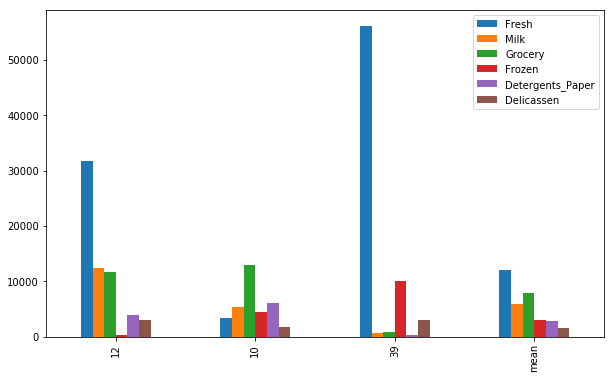

In [8]:
data_mean = data_stats.loc['mean',:]
sample_bar = sample_data.append(data_mean)
sample_bar.index = indices + ['mean']
# Plot bar plot
sample_bar.plot(kind='bar', figsize=(10,6))

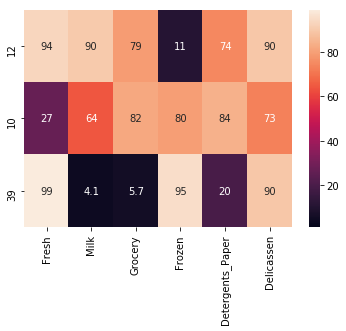

In [9]:
import seaborn as sns

# First, calculate the percentile ranks of the whole dataset.
percentiles = data.rank(pct=True)
# Then, round it up, and multiply by 100
percentiles = 100*percentiles.round(decimals=3)

# Select the indices you chose from the percentiles dataframe
percentiles = percentiles.iloc[indices]

sns.heatmap(percentiles, vmin=1, vmax=99, annot=True)

### Can we get an idea of who the customers are by looking at the samples?

* 12 - Indicates an upscale restaurant:
    - low on Frozen
    - high on Fresh, Milk and Deli (cheese etc.)
 
 
* 10 - Indicates a dept. store selling groceries
    - low on Fresh
    - High on Grocery, Frozen and Detergents/Paper


* 39 - Indicates a corner store or a deli
    - high on Fresh, Frozen and Deli
    - low on Mild and Groceries

## Feature relevance

In this section, we try and understand how the different categories are related to each other. For one, we try and understand if there's any dependence between the various features, that is, does amount spent on one catogory indicate a proportional spend on another one.

For this we try to look at how the data would predict the spend on each category. We remove the column for the category we are trying to invetigate and have this as the target. With the remaining data as our training set, we try to see how how the predictions are. If the $R^2$ value is high, it implies there is a correlation and that the feature is not independent. If it's low or negative, we conclude that the feature can't be predicted from the remaining data and that it's independent and should be accounted for 

In [10]:
# Imports
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor

/home/soumyo/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
# Create list to loop through
dep_vars = list(data.columns)

# Create loop to test each feature as a dependent variable
for var in dep_vars:
    new_data = data.drop([var],axis=1)
    target_feature = data[var]
    X_train, X_test, y_train, y_test = train_test_split(new_data, target_feature, test_size=0.25, random_state=10)
    dtr = DecisionTreeRegressor(random_state=10)
    dtr.fit(X_train, y_train)
    # Report the score of the prediction using the testing set
    # Returns R^2
    score = dtr.score(X_test, y_test)
    print 'R2 score for {} as dependent variable: {}'.format(var, score)

R2 score for Fresh as dependent variable: -0.379170072447
R2 score for Milk as dependent variable: -0.442085754637
R2 score for Grocery as dependent variable: 0.723800832652
R2 score for Frozen as dependent variable: 0.0548481103591
R2 score for Detergents_Paper as dependent variable: 0.494381677643
R2 score for Delicassen as dependent variable: -10.5626610325


We see that the $R^2$ value of most features is negative or low which means that other features are not able to explain the variation in them. Grocery, however, has a $R^2$ value of 0.72 which is still not very high but it definitely shows some correlation or dependency on other features. We can explore this further.

From the $R^2$ values, we can conclude that all features are relevant for explaining the variations in the data with Grocery being somewhat dependent on the others.

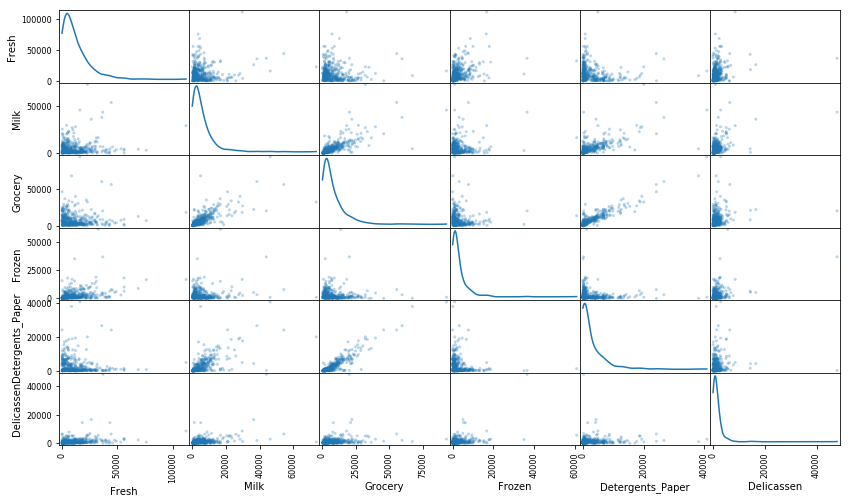

In [12]:
#visualize the correlation between different features and see how the the values of each feature are distributed
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

We notice two key things:
* the data is not normally distributed. It is very skewed to lower values
* Grocery shows correlation with Detergents_Paper. There is a mild correlation observed with Milk and Detergents_Paper, and Milk and Grocery

In the following we validate our hypothesis by looking at the correlation matrix

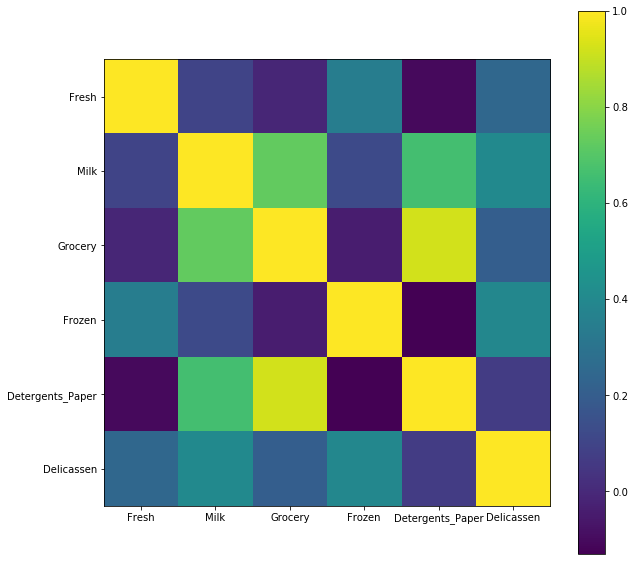

In [13]:
corr = data.corr()
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);
plt.colorbar()
plt.show()

We see that Grocery is strongly correlated with Detergents_Paper with $R^2 > 0.9$. Grocery also shows some correlation with Milk. This indicated why we got such a $R^2 = 0.72$ when we regressed it with other features.

This implies that Grocery is not the most relevant feature in determining customers' spending habits

Since we have observed a large skew in the data, we take the natural logarithm of the data whichh looks more normal as we see below

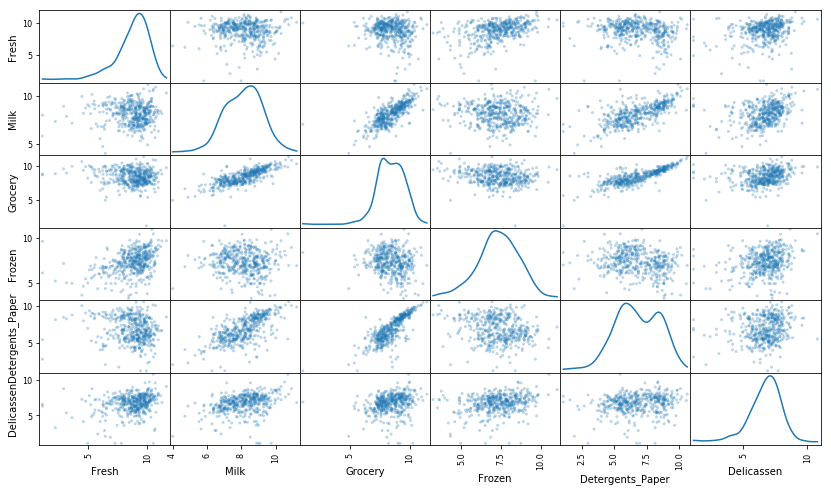

In [14]:
log_data = np.log(data)
log_samples = np.log(sample_data)
# scatter matrix for each pair of features in the scaled data
pd.plotting.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

We make two key observations from scatter matrix the log scaled data
* the skewness has been mostly fixed and the data looks more normal
* correlations between Grocery and Milk have become more prominent while correlation between Grocery and Detergents_Paper which was strong in the original data has become weaker as confirmed from the correlation matrix below

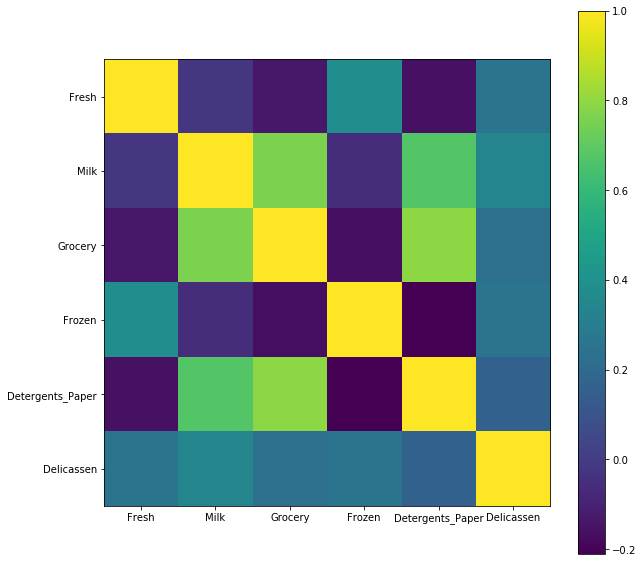

In [15]:
log_corr = log_data.corr()
fig1, ax1 = plt.subplots(figsize=(10, 10))
plt.imshow(log_corr)
plt.xticks(range(len(corr.columns)), corr.columns);
plt.yticks(range(len(corr.columns)), corr.columns);
plt.colorbar()
plt.show()

## Outlier detection

In the next step we identify outliers and remove them from our data. This is crucial as a clustering and regression algorithms are very sensitive to outliers.

We do this by identifying values which fall outside the interquartile range

In [16]:
import itertools

outliers_lst  = []

# For each feature find the data points with extreme high or low values and store its index in outliers_lst
for feature in log_data.columns:
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data.loc[:, feature], 25)

    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data.loc[:, feature], 75)

    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5 * (Q3 - Q1)

    

    # The tilde sign ~ means not
    # So here, we're finding any points outside of Q1 - step and Q3 + step
    outliers_rows = log_data.loc[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step)), :]
    # display(outliers_rows)

    outliers_lst.append(list(outliers_rows.index))

#list of all outlier indices
outliers = list(itertools.chain.from_iterable(outliers_lst))

#list of unique outlier indices
unique_outliers = list(set(outliers))

#list of duplicate outlier indices
dup_outliers = list([x for x in unique_outliers if outliers.count(x) > 1])

#remove duplicate outliers from data
good_data = log_data.drop(log_data.index[dup_outliers]).reset_index(drop = True)

In [17]:
#Check the shape of original data and good_data to see how many outliers have been removed
print data.shape
print good_data.shape

(440, 6)
(435, 6)


## Principal Component Analysis (PCA)

After the data has been converted to a more normal form, we perform PCA to identify the key deimensions which maximize the variance of the feautures involved.

In addition to finding these dimensions, PCA will also report the explained variance ratio of each dimension — how much variance within the data is explained by that dimension alone. We note that a PCA dimension is a linear combination of existing features and can be treated as a new feature

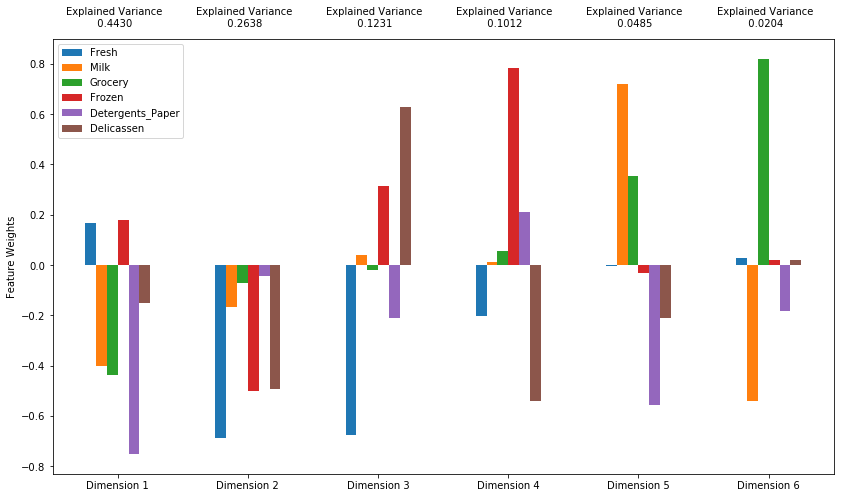

In [18]:
from sklearn.decomposition import PCA

#apply PCA by fitting the good_data with the same number of dimensions as in the original data
pca = PCA(n_components=6)
# Fit
pca.fit(good_data)

#transform the samples
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

In [19]:
# display PCA results
pca_results

,Explained Variance,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Dimension 1,0.4430,0.1675,-0.4014,-0.4381,0.1782,-0.7514,-0.1499
Dimension 2,0.2638,-0.6859,-0.1672,-0.0707,-0.5005,-0.0424,-0.4941
Dimension 3,0.1231,-0.6774,0.0402,-0.0195,0.3150,-0.2117,0.6286
Dimension 4,0.1012,-0.2043,0.0128,0.0557,0.7854,0.2096,-0.5423
Dimension 5,0.0485,-0.0026,0.7192,0.3554,-0.0331,-0.5582,-0.2092
Dimension 6,0.0204,0.0292,-0.5402,0.8205,0.0205,-0.1824,0.0197


In [20]:
# display cumulative sum of explained variance
pca_results['Explained Variance'].cumsum()

Dimension 1    0.4430
Dimension 2    0.7068
Dimension 3    0.8299
Dimension 4    0.9311
Dimension 5    0.9796
Dimension 6    1.0000
Name: Explained Variance, dtype: float64

## Key insights

* 70.68% of the variance in the data is explained by the first and second principal components.
    
* 93.11% of the variance in the data is explained by the first four principal components.
    
## Components breakdown:

* The first principal component (PC1):
    * An increase in PC1 is associated with large decrease in "Milk", "Grocery" and "Detergents_Paper" spending.
    * These features best represent PC1.
    * This is in line with our initial findings where the 3 features are highly correlated.


* The second principal component (PC2):
    * An increase in PC2 is associated with large decrease in "Fresh", "Frozen" and "Delicatessen" spending.
    * These features best represent PC2.
    * This makes sense as PC1 represents different features. And in PC2, the features in PC1 have very small positive weights.


* The third principal component (PC3):
    * An increase in PC3 is associated with a large increase in "Delicatessen" and a large decrease in "Fresh" spending.
    * These features best represent PC3.


* The fourth principal component (PC4):
    * An increase in PC4 is associated with a large increasing in "Frozen" and a large decrease in "Delicatessen" spending.
    * These features best represent PC4.

We look at the sample data and see how it's represented according to the 6 PCA dimensions

In [21]:
#display the PCA tranformed samples
pd.DataFrame(pca_samples, columns = pca_results.index.values, index=indices)

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
12,-2.240634,-1.241874,-1.072938,-1.958877,0.216015,-0.178153
10,-2.088740,-0.700643,0.853699,1.010543,-0.558651,0.249544
39,3.042576,-2.585362,0.196486,-0.075725,-1.421270,0.009334


## Dimensionality reduction

In the following we apply PCA with fewer dimensions. We tranform the sample data analogously to fewer dimensions and note that it has barely changed

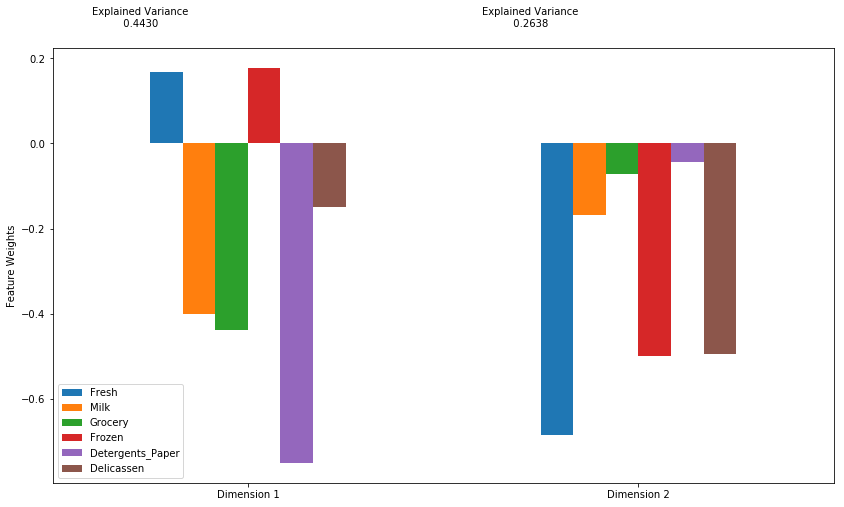

In [22]:
# apply PCA with fewer dimensions

pca = PCA(n_components=2)
# Fit
pca.fit(good_data)

reduced_data = pca.transform(good_data)
# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

pca_results_reduced = rs.pca_results(good_data, pca)

In [23]:
#transform the samples
pca_samples_reduced = pca.transform(log_samples)
pd.DataFrame(pca_samples_reduced, columns = pca_results_reduced.index.values, index=indices)

,Dimension 1,Dimension 2
12,-2.240634,-1.241874
10,-2.088740,-0.700643
39,3.042576,-2.585362


## Clustering the data using K-means clustering algorithm

Since we don't know the number of clusters *a priori*, we scan through different number of clusters and evaluate the *silhouette coefficient* to get the optimal number.  

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [25]:
# we scan through a range of clusters between 2 & 11
for n_clusters in range(2,11):
    clusterer = KMeans(n_clusters=n_clusters).fit(reduced_data)
    
    # Predict the cluster for each data point
    preds = clusterer.predict(reduced_data)
    
    # Find the cluster centers
    centers = clusterer.cluster_centers_
    
    # Predict the cluster for each transformed sample data point
    sample_preds = clusterer.predict(pca_samples_reduced)
    
    # Calculate the mean silhouette coefficient for the number of clusters chosen
    score = silhouette_score(reduced_data, preds, metric='euclidean')
    print "For n_clusters = {}. The average silhouette_score is : {}".format(n_clusters, score)

For n_clusters = 2. The average silhouette_score is : 0.426281015469
For n_clusters = 3. The average silhouette_score is : 0.397138208845
For n_clusters = 4. The average silhouette_score is : 0.331245916061
For n_clusters = 5. The average silhouette_score is : 0.350829586696
For n_clusters = 6. The average silhouette_score is : 0.364078878473
For n_clusters = 7. The average silhouette_score is : 0.363043766257
For n_clusters = 8. The average silhouette_score is : 0.36548780774
For n_clusters = 9. The average silhouette_score is : 0.363672408656
For n_clusters = 10. The average silhouette_score is : 0.346884441809


**The best score is obtained when the number of clusters is two as seen above**

In [26]:
# fit k-means with 2 clusters
clusterer = KMeans(n_clusters=2).fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_
sample_preds = clusterer.predict(pca_samples_reduced)

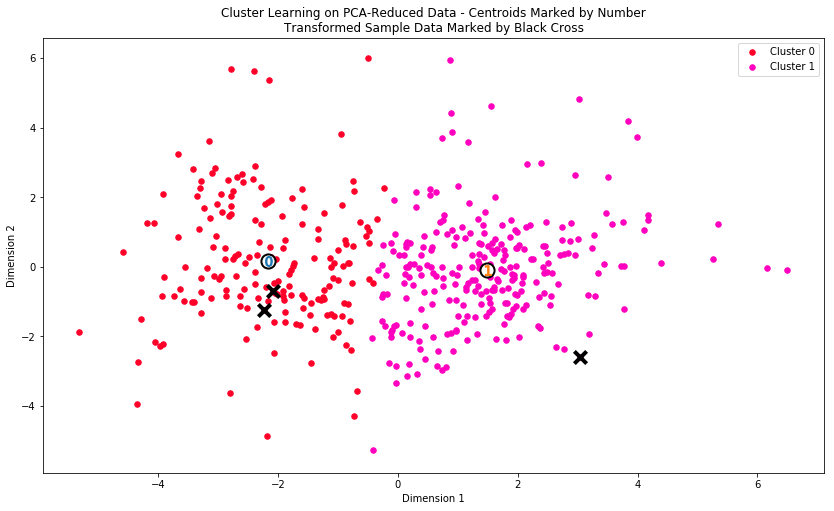

In [27]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

From the plot above, we can clearly ideatify the two customer segments. This is the advantage of using the reduced dimensional data through PCA which allows us to visualize the outcome of clustering

### Tracing back from reduced dimensions to the full dimensionality of the original data

The cluster centroids are indicative of the average customer in that group. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In [28]:
# Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.columns)
true_centers.index = segments
true_centers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 0,4005.0,7900.0,12104.0,952.0,4561.0,1036.0
Segment 1,8867.0,1897.0,2477.0,2088.0,294.0,681.0


Check deviations of the average customer spend in both segments from the median

In [29]:
true_centers - data.median()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 0,-4499.0,4273.0,7348.5,-574.0,3744.5,70.5
Segment 1,363.0,-1730.0,-2278.5,562.0,-522.5,-284.5


Check deviations of the average customer spend in both segments from the mean

In [30]:
true_centers - data.mean()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Segment 0,-7995.297727,2103.734091,4152.722727,-2119.931818,1679.506818,-488.870455
Segment 1,-3133.297727,-3899.265909,-5474.277273,-983.931818,-2587.493182,-843.870455


## What do the segments mean in terms of customers' spending habits?

Since the mean is sensitive to outliers and would not yield meaningful comparisons, we look at the deviations of the average customer in both segments from the median to identify which type of customer each segment represents

* Segment 0:
    * Establishments in this segment have above median spending on "Milk", "Grocery" and "Detergents_Paper".
    * This could represent restaurants and cafes.


* Segment 1:
    * Establishments in this segment have above median spending on "Fresh" and "Frozen".
    * This could represent typical retailers such as markets specializing in fresh and frozen food.

Let's look at the samples' sapending and see which segment they belong to. Comparing these two will tell us if the segmentation makes sense

In [31]:
sample_data

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
12,31714,12319,11757,287,3881,2931
10,3366,5403,12974,4400,5977,1744
39,56159,555,902,10002,212,2916


In [32]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", indices[i], "predicted to be in Segment", pred


Sample point 12 predicted to be in Segment 0
Sample point 10 predicted to be in Segment 0
Sample point 39 predicted to be in Segment 1


Finally, we see an interesting similarity in the clusters we obtained and the groups that were already in the data through the 'Channel' feature which we decided to ignore for this project. Grouping the PCA reduced data by Channels on a scatter plot, we get

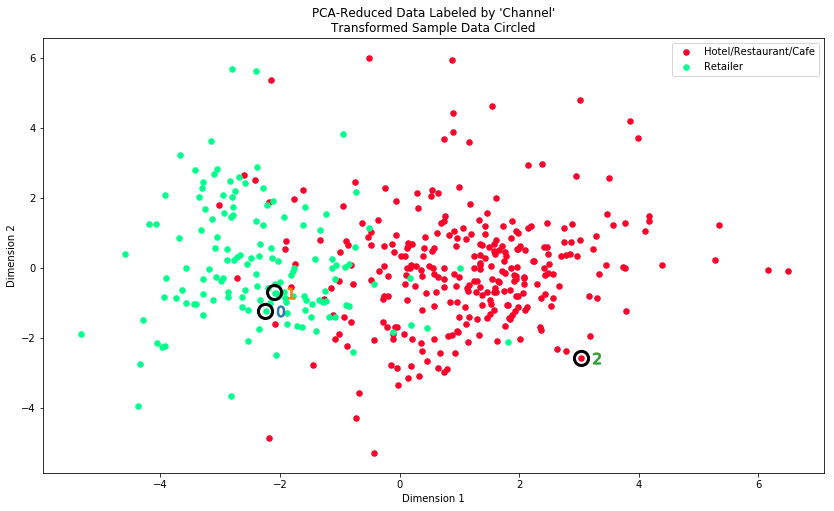

In [33]:
# Display the clustering results based on 'Channel' data
channel = pd.DataFrame(full_data['Channel'], columns = ['Channel'])
rs.channel_results(reduced_data, dup_outliers, pca_samples, channel)

## Validation of PCA and K-means clustering

Without knowledge of the channels, our algorithm was able to segment the data into two clusters. They correspond to the following channels (roughly)


* Cluster 0 - Hotel/Restaurant/Cafe
* Cluster 1 - Retailer

## Applications of clustering

* Once the segments have been identified, companies can run AB testing on each segment to identify if a particular strategy they are trying to implement will work or not. This could be a marketing strategy, change in delivery service etc.


* We can identify the clusters as new engineered features. For new customers, using classification algorithms, we can predict which segment they may fall into based on their estimated expense beforehand. This leads to more targeted actions on new customers